In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
#from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import sys

%matplotlib inline

In [3]:
# Create device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Load MNIST dataset and create dataloaders
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('./mnist', train=True, download=True, transform=transform)
test_dataset = MNIST('./mnist', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [18]:
class LeNet(nn.Module):
    """ Implementation LeNet++ """
    
    def __init__(self, final_layer):
        super(LeNet, self).__init__()
        
        # Save result of stage 4 for using in center loss
        self.stage4_result = np.zeros((10, 2))
        
        # Layers of network
        # Stage 1
        self.stage1 = nn.Sequential(nn.Conv2d(1, 32, 5, stride=1, padding=2), nn.PReLU(),
                                   nn.Conv2d(32, 32, 5, stride=1, padding=2), nn.PReLU(),
                                   nn.MaxPool2d(2, stride=2, padding=0))
        
        #Stage 2
        self.stage2 = nn.Sequential(nn.Conv2d(32, 64, 5, stride=1, padding=2), nn.PReLU(),
                                   nn.Conv2d(64, 64, 5, stride=1, padding=2), nn.PReLU(),
                                   nn.MaxPool2d(2, stride=2, padding=0))
        
        #Stage 3
        self.stage3 = nn.Sequential(nn.Conv2d(64, 128, 5, stride=1, padding=2), nn.PReLU(),
                                   nn.Conv2d(128, 128, 5, stride=1, padding=2), nn.PReLU(),
                                   nn.MaxPool2d(2, stride=2, padding=0))
        
        #Stage 4, size = 28(image_size) / 2**3(3 x MaxPool(2))
        self.stage4 = nn.Linear(3*3*128, 2)
        
        #Stage 5, we have 10 numbers and we need 10 outputs
        self.stage5 = nn.Sequential(nn.PReLU(), nn.Linear(2, 10), final_layer)

    def forward(self, x):
        """ Implement forward path """
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = x.view(x.size(0), -1)
        
        # Save result for use in Center Loss
        self.stage4_result = self.stage4(x)
        
        output = self.stage5(self.stage4_result)
        return output
    
    def get_stage4(self):
        """ Return saved result for use in Center Loss """
        return self.stage4_result

In [294]:
class CenterLoss(nn.Module):
    """ Implementation center loss """
    
    def __init__(self, alpha=0.5):
        super(CenterLoss, self).__init__()
        self.centers = nn.Parameter(torch.zeros((10, 2)), requires_grad=True)
        self.alpha = alpha
        
    def forward(self, outputs, y):
        global centers
        centers = self.centers.cpu().data.numpy()
        indexing_centers = torch.index_select(self.centers, 0, y.cpu()).to(device)
        return torch.dist(outputs, indexing_centers) / (2 * y.shape[0])
    
    def backward(self, fc_outputs, y):
        global centers
        centers = self.centers.cpu().data.numpy()
        indexing_centers = torch.index_select(self.centers, 0, y.cpu())
        return fc_outputs.cpu() - indexing_centers
    
    def update(self, fc_outputs, y):
        global centers
        indexing_centers = torch.index_select(self.centers, 0, y.cpu())
        delta = torch.zeros(10,2)
        #len_sum = torch.ones(10)
        #delta = torch.empty((10,2))
        #len_sum = torch.histc(y.float(), bins=10, min=0, max=9)
        len_sum = torch.ones((10, 2))
        #len_sum += 1
        for j in range(10):
            for i in range(y.shape[0]):
                if y[i] == j:
                    #print (delta[j], len_sum[j], fc_outputs.cpu()[i])
                    delta[j].add_(torch.sub(self.centers.cpu()[j], fc_outputs.cpu()[i]))
                    #summ[j] += self.centers.cpu()[j] - fc_outputs.cpu()[i]
                    len_sum[j].add_(1)
                    #print (delta[j], len_sum[j], fc_outputs.cpu()[i])
        delta.div_(len_sum)
            #delta[j] = summ[j]/len_sum[j]
        delta.mul_(self.alpha)
        self.centers.data = torch.sub(self.centers, delta).data
        centers = self.centers.cpu().data.numpy()

In [295]:
def metrics_plot(train_loss_epochs, test_loss_epochs, train_acc_epochs, test_acc_epochs):
        """ Draw plots for metrics """
        
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(train_loss_epochs[1:], label='Train')
        plt.plot(test_loss_epochs[1:], label='Test')
        plt.xlabel('Epochs', fontsize=16)
        plt.ylabel('Loss', fontsize=16)
        plt.legend(loc=0, fontsize=16)
        plt.grid('on')
        plt.subplot(1, 2, 2)
        plt.plot(train_acc_epochs[1:], label='Train')
        plt.plot(test_acc_epochs[1:], label='Test')
        plt.xlabel('Epochs', fontsize=16)
        plt.ylabel('Accuracies', fontsize=16)
        plt.legend(loc=0, fontsize=16)
        plt.grid('on')
        plt.show()
    
def activation_plot(y_train, y_test, draw_centers=False):
    """ Draw plots for neuron's activation """
    
    global accumulate_layer, centers
    train_size = 50000
    test_size = 10000
    sample_size = train_size + test_size
    
    plt.figure(figsize=(20, 10))
    for x in range(10):
        plt.subplot(1, 2, 1)
        plt.scatter(accumulate_layer[-sample_size:-test_size][:, 0][y_train[-train_size:] == x], 
                    accumulate_layer[-sample_size:-test_size][:, 1][y_train[-train_size:] == x], 
                    label=str(x), s=2)
        if draw_centers:
            plt.scatter(centers[:, 0], centers[:, 1], s=20)
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.scatter(accumulate_layer[-test_size:][:, 0][y_test == x], 
                    accumulate_layer[-test_size:][:, 1][y_test == x], 
                    label=str(x), s=3)
        if draw_centers:
            plt.scatter(centers[:, 0], centers[:, 1], s=20)
        plt.legend()
        
    plt.subplot(1, 2, 1)
    plt.title("Train")
    plt.xlabel('Activation of the 1st neuron', fontsize=12)
    plt.ylabel('Activation of the 2nd neuron', fontsize=12)
    plt.subplot(1, 2, 2)
    plt.title("Test")
    plt.xlabel('Activation of the 1st neuron', fontsize=12)
    plt.ylabel('Activation of the 2nd neuron', fontsize=12)
    plt.show()

In [296]:
def train(network, epochs, main_lr=1e-4, center_lr=0.5, _lambda=0.5, plot=True, 
          standart_loss=nn.NLLLoss(), center_loss=CenterLoss(), delta_manualy=False,
          optim=torch.optim.Adam, center_optim=torch.optim.SGD):
    """ Train network and collect metrics """
    
    # Arrays for metrics
    train_loss_epochs = []
    train_acc_epochs = []
    test_loss_epochs = []
    test_acc_epochs = []
    
    # Calculate loss
    loss = lambda x, y: standart_loss(x, y) + _lambda * center_loss(network.get_stage4(), y)
    
    # Initialised optimizers
    optimizer = optim(network.parameters(), lr=main_lr)
    center_optimizer = center_optim(center_loss.parameters(), lr=center_lr)
    
    # Start main loop with train and test step
    try:
        for epoch in range(epochs):
            loss_epoch = []
            acc_epoch = []
            
            # Train step
            for i, sample in enumerate(train_loader):
                sys.stdout.write('\rEpoch {0}... Train: {1:d}/{2:d}'.format(
                        epoch, i, len(train_loader)))
                
                # Get new sample of batch
                X, y = sample
                X = X.to(device)
                y = y.to(device)
                
                # Train network on batch
                prediction = network(X)
                loss_batch = loss(prediction, y)
                optimizer.zero_grad()
                if not delta_manualy:
                    center_optimizer.zero_grad()
                loss_batch.backward()
                if delta_manualy:
                    center_loss.backward(network.get_stage4(), y)
                    center_loss.update(network.get_stage4(), y)
                else:
                    center_optimizer.step()
                optimizer.step()
                
                # Calculate metrics
                acc_batch = (np.argmax(prediction.cpu().data.numpy(), 1) == y.cpu().data.numpy()).mean()
                loss_epoch.append(loss_batch.data[0])
                acc_epoch.append(acc_batch)
                
            # Get average metrics by epoch for train step
            train_loss_epochs.append(np.mean(loss_epoch))
            train_acc_epochs.append(np.mean(acc_epoch))
            
            loss_epoch = []
            acc_epoch = []
            
            # Test step
            for i, sample in enumerate(test_loader):
                sys.stdout.write('\rEpoch {0}... Test: {1:d}/{2:d}'.format(
                        epoch, i, len(test_loader)))
                
                # Get new sample of batch
                X, y = sample
                X = X.to(device)
                y = y.to(device)
                
                # Get predict of batch and calculate loss
                prediction = network(X)
                loss_batch = loss(prediction, y)
                
                # Calculate metrics
                acc_batch = (np.argmax(prediction.cpu().data.numpy(), 1) == y.cpu().data.numpy()).mean()
                loss_epoch.append(loss_batch.data[0])
                acc_epoch.append(acc_batch)
            
            # Get average metrics by epoch for test step
            test_loss_epochs.append(np.mean(loss_epoch))
            test_acc_epochs.append(np.mean(acc_epoch))
            sys.stdout.write('\rEpoch {0}... (Train/Test) NLLLoss: {1:.3f}/{2:.3f}...  Acc: {3:.3f}/{4:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                               train_acc_epochs[-1], test_acc_epochs[-1]))
        
        #Draw metrics plot if needed
        if plot:
            metrics_plot(train_loss_epochs, test_loss_epochs, train_acc_epochs, test_acc_epochs)
    except KeyboardInterrupt:
        pass

In [297]:
# Create function for forward hook
accumulate_hook = None
def accumulate(self, input, output):
    """ Function for forward hook which accumulate first fc layer weights """
    global accumulate_layer
    if accumulate_layer is None:
        accumulate_layer = output.cpu().data.numpy()
    else:
        accumulate_layer = np.concatenate((accumulate_layer, output.cpu().data.numpy()))

In [298]:
def get_result(model, _lambda, delta_manualy=False, draw_centers=False):
    """ Accumulate all previous functions
        Train model
        Draw plot
    """
    
    # Remove old forward hook if needed
    global accumulate_layer, accumulate_hook
    accumulate_layer = None
    if accumulate_hook is not None:
        accumulate_hook.remove()

    train(model, epochs=5, _lambda=_lambda, center_optim=torch.optim.Adam, delta_manualy=delta_manualy)

    # Get y marks for train and test
    y_train = []
    for (x, y) in train_loader:
        y_train.extend(y.data.numpy())

    y_test = []
    for (x, y) in test_loader:
        y_test.extend(y.data.numpy())

    y_train = np.array(y_train)
    y_test = np.array(y_test)

    # Register new forward hook
    accumulate_hook = model.stage4.register_forward_hook(accumulate)

    # Train model in 1 epochs and get new accumulate_layer
    train(model, epochs=1, plot=False, delta_manualy=delta_manualy)

    # Delete hook, so that memory doesn't leak
    accumulate_hook.remove()

    activation_plot(y_train, y_test, draw_centers=draw_centers)

    # Free memory
    del accumulate_layer
    accumulate_layer = None

In [304]:
# Create main model
final_loss = nn.LogSoftmax(dim=1)
model = LeNet(final_loss).to(device)

### Start train model and draw plots with lambda=0

Epoch 0... Train: 2/469

/home/anton.loskutov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 0... Test: 13/79469

/home/anton.loskutov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 4... (Train/Test) NLLLoss: 0.370/0.348...  Acc: 0.941/0.950

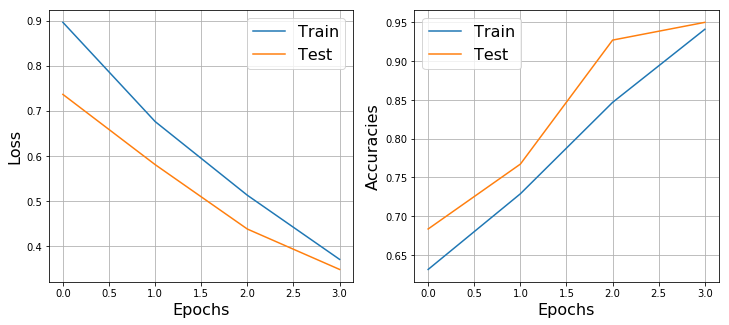

Epoch 0... (Train/Test) NLLLoss: 0.546/0.510...  Acc: 0.958/0.960

/home/anton.loskutov/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


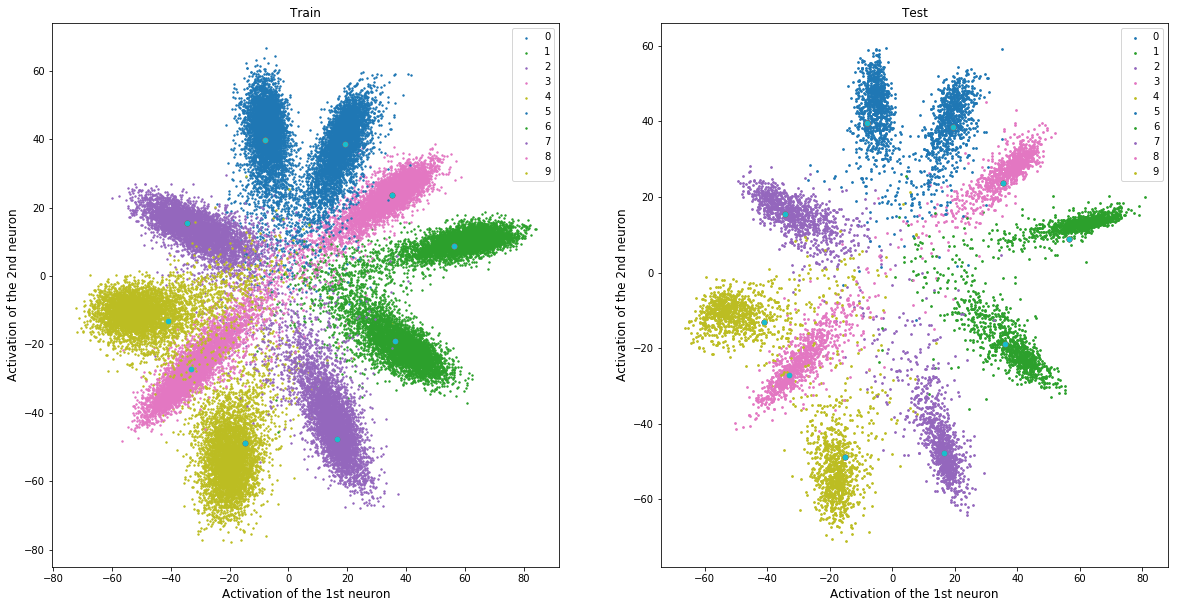

In [305]:
get_result(model, _lambda=0.1, delta_manualy=True, draw_centers=True)

Epoch 0... Train: 7/469

/home/anton.loskutov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 0... Test: 5/79/469

/home/anton.loskutov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 4... (Train/Test) NLLLoss: 0.382/0.338...  Acc: 0.930/0.944

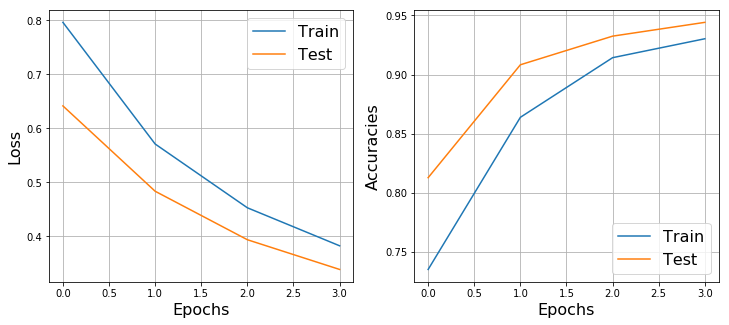

Epoch 0... (Train/Test) NLLLoss: 0.622/0.578...  Acc: 0.943/0.951

/home/anton.loskutov/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


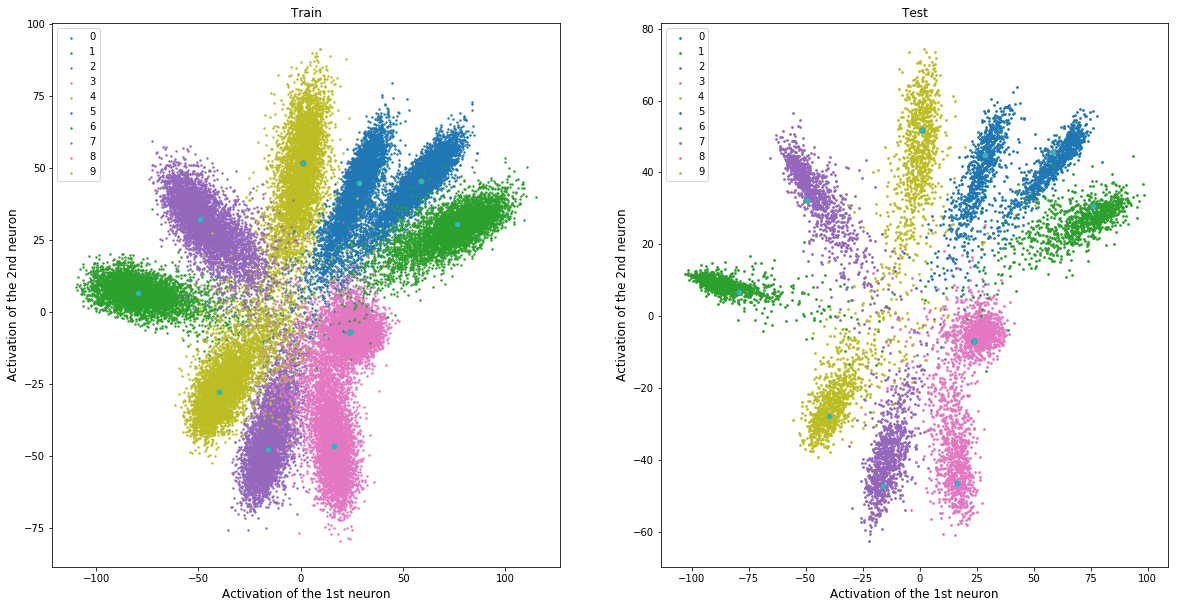

In [306]:
# Create main model
final_loss = nn.LogSoftmax(dim=1)
model2 = LeNet(final_loss).to(device)
get_result(model2, _lambda=0.1, delta_manualy=False, draw_centers=True)

### Continue train model and draw plots with lambda = 0.1

Epoch 0... Train: 6/469

/home/anton.loskutov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 0... Test: 2/79/469

/home/anton.loskutov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:72: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 24... (Train/Test) NLLLoss: 0.011/0.165...  Acc: 1.000/0.981

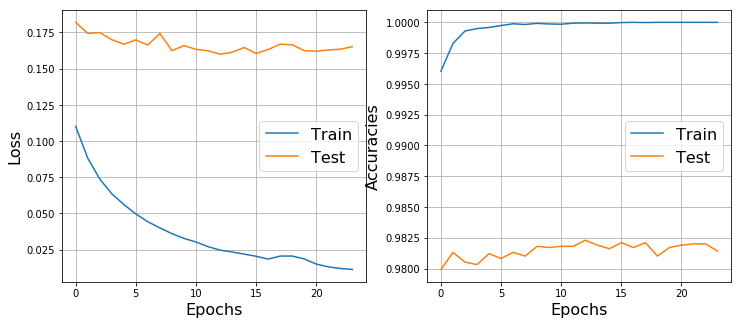

Epoch 0... (Train/Test) NLLLoss: 0.073/0.291...  Acc: 1.000/0.982

/home/anton.loskutov/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


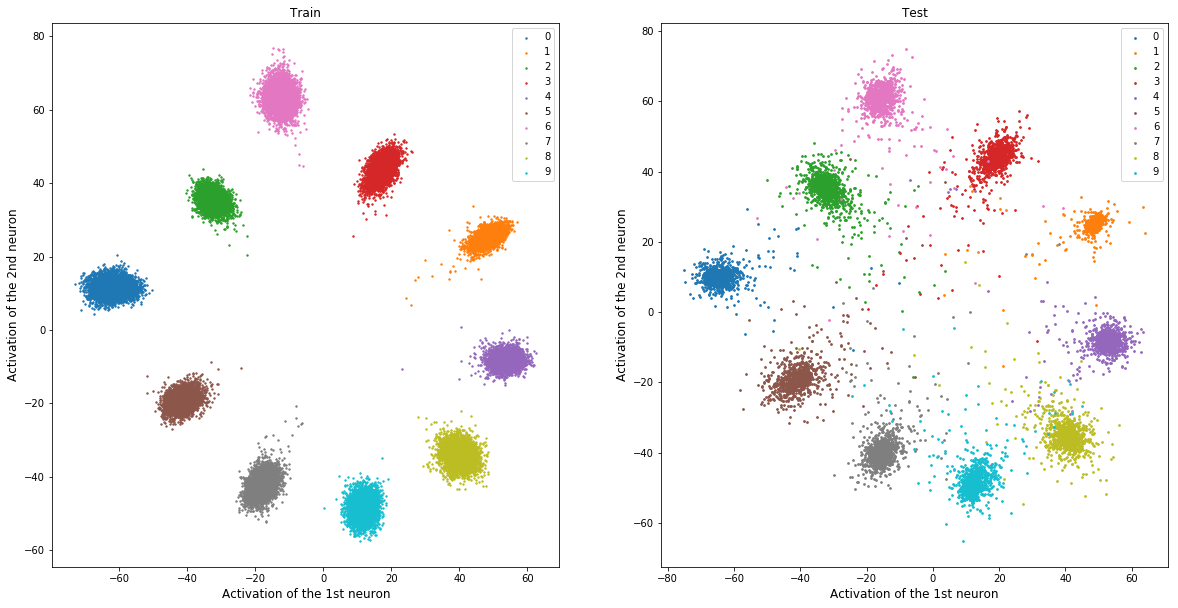

In [12]:
get_result(model, _lambda=0.1)

### Continue train model and draw plots with lambda=1

Epoch 0... Train: 8/469

/home/anton.loskutov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 0... Test: 9/79/469

/home/anton.loskutov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:72: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 24... (Train/Test) NLLLoss: 0.032/0.225...  Acc: 1.000/0.982

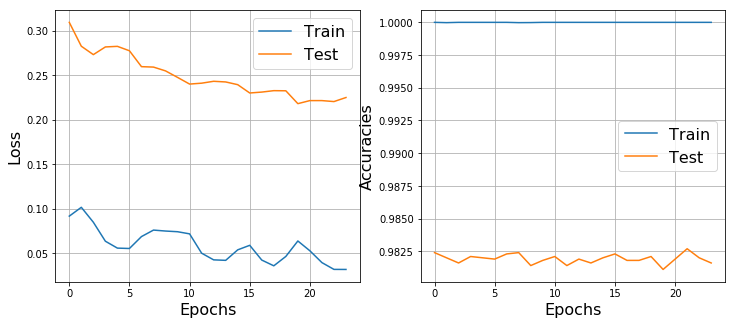

Epoch 0... (Train/Test) NLLLoss: 0.029/0.170...  Acc: 1.000/0.981

/home/anton.loskutov/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


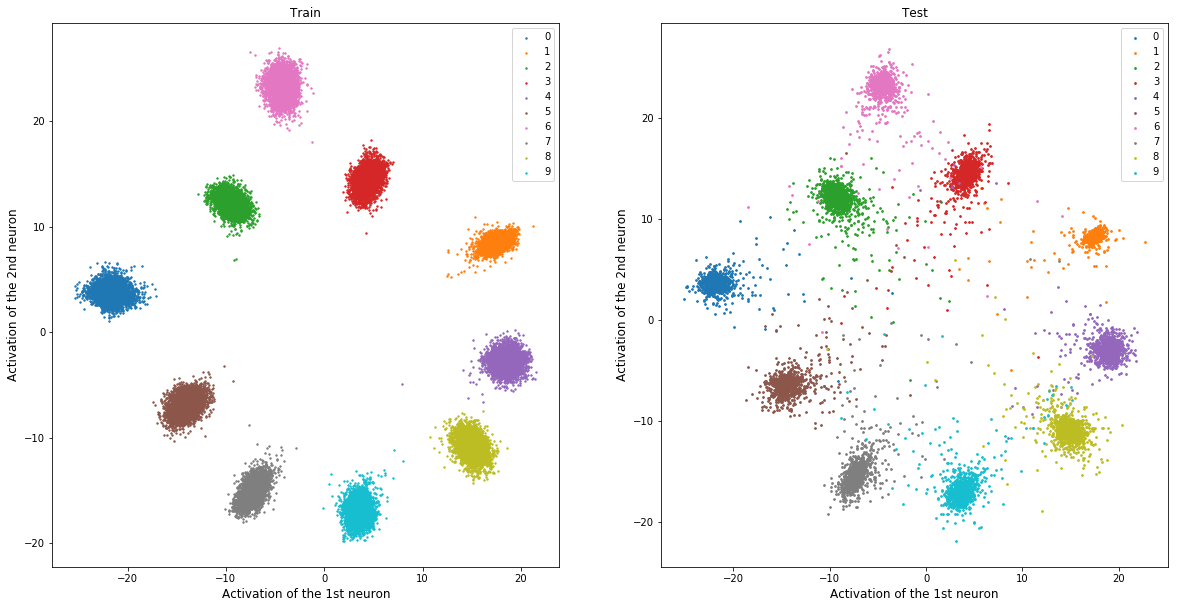

In [13]:
get_result(model, _lambda=1)

In [3]:
import numpy as np
import torch
a = torch.from_numpy(np.array([1, 2, 3, 4, 5, 6, 7, 8]))
b = torch.from_numpy(np.array([1, 1, 1, 3 ,3]))
torch.index_select(a, index=b, dim=0)

tensor([ 2,  2,  2,  4,  4])